In [4]:
#Example usage of the preprocess_and_filter_bots function 
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
import csv
import pandas as pd
from pyspark.sql.functions import count
from preprocessing_func import preprocess_and_filter_bots

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("RedditSentimentAnalysis") \
    .master("spark://192.168.2.46:7077") \
    .config("spark.dynamicAllocation.enabled", True) \
    .config("spark.shuffle.service.enabled", False) \
    .config("spark.dynamicAllocation.executorIdleTimeout", "30s") \
    .config("spark.executor.cores", 2) \
    .config("spark.cores.max", 4) \
    .config("spark.driver.port", 9999) \
    .config("spark.blockManager.port", 10005) \
    .getOrCreate()

print("✅ Spark NLP Session Started")

# Define file paths
reddit_json_path = "hdfs://192.168.2.46:9000/data/corpus-webis-tldr-17.json"
botlist_csv_path = "/home/ubuntu/DEI-project/preprocessing/preprocessing files/botlist.csv"

# Run preprocessing and bot filtering
df_cleaned = preprocess_and_filter_bots(spark, reddit_json_path, botlist_csv_path)

# Show the first few cleaned rows
df_cleaned.select("author", "normalizedBody").show(10, truncate=False)


✅ Spark NLP Session Started
 Loading Reddit JSON data from HDFS...
 Loading bot list from CSV...
 Loaded 414 bot names.
 Preprocessing completed. Ready for sentiment analysis!
+------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

✅ Spark NLP Session Started
Loaded 27 positive words and 27 negative words.


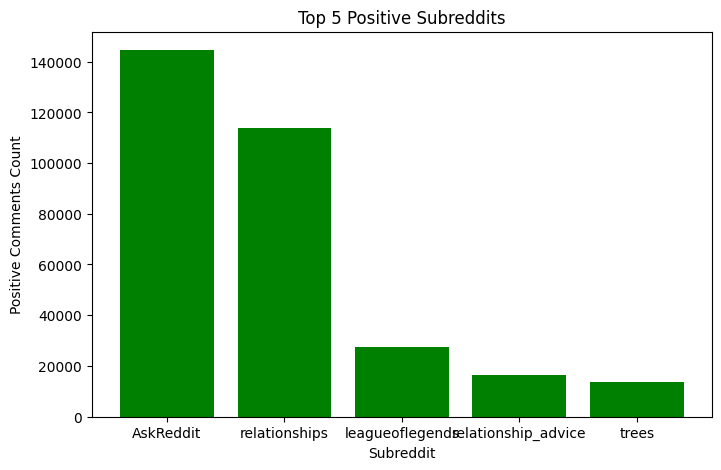

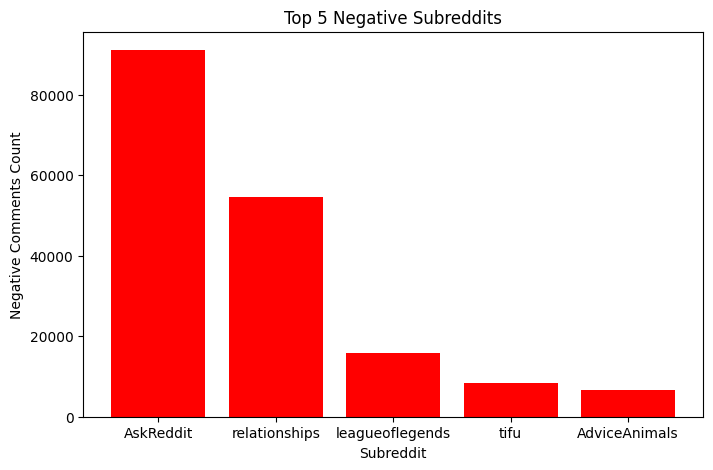

✅ Sentiment analysis and visualization completed


In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, count
from pyspark.sql.types import StringType
import pandas as pd
import csv
import matplotlib.pyplot as plt

# Initialize Spark Session
# spark = SparkSession.builder \
#     .appName("RedditSentimentAnalysis") \
#     .master("spark://192.168.2.46:7077") \
#     .config("spark.dynamicAllocation.enabled", True) \
#     .config("spark.shuffle.service.enabled", False) \
#     .config("spark.dynamicAllocation.executorIdleTimeout", "30s") \
#     .config("spark.executor.cores", 2) \
#     .config("spark.cores.max", 4) \
#     .config("spark.driver.port", 9999) \
#     .config("spark.blockManager.port", 10005) \
#     .getOrCreate()

print("✅ Spark NLP Session Started")

# Define file paths
reddit_json_path = "hdfs://192.168.2.46:9000/data/corpus-webis-tldr-17.json"
botlist_csv_path = "/home/ubuntu/DEI-project/preprocessing/preprocessing files/botlist.csv"
positive_words_file = "/home/ubuntu/DEI-project/preprocessing/preprocessing files/positive_words.csv"
negative_words_file = "/home/ubuntu/DEI-project/preprocessing/preprocessing files/negative_words.csv"

# Load Reddit comments from HDFS
df = spark.read.json(reddit_json_path)

# Load bot list
bot_df = pd.read_csv(botlist_csv_path)
bot_list = bot_df["AAbot"].dropna().unique().tolist()

# Remove bot-generated comments
df_filtered = df.filter(~col("author").isin(bot_list))

# Load positive and negative words from CSV files
def load_words_from_csv(filepath):
    words = set()
    with open(filepath, "r") as file:
        reader = csv.reader(file)
        next(reader)  # Skip header
        for row in reader:
            if row:
                words.add(row[0].strip().lower())
    return words

# Load words
positive_words = load_words_from_csv(positive_words_file)
negative_words = load_words_from_csv(negative_words_file)

print(f"Loaded {len(positive_words)} positive words and {len(negative_words)} negative words.")

# Sentiment analysis function
def analyze_sentiment(text):
    if not text:
        return "neutral"
    words = set(text.lower().split())
    pos_count = len(words & positive_words)
    neg_count = len(words & negative_words)

    if pos_count > neg_count:
        return "positive"
    elif neg_count > pos_count:
        return "negative"
    return "neutral"

# Register UDF
sentiment_udf = udf(analyze_sentiment, StringType())

# Apply sentiment analysis
df_result = df_filtered.withColumn("sentiment", sentiment_udf(col("normalizedBody")))

# Aggregate sentiment counts by subreddit
subreddit_sentiment = df_result.groupBy("subreddit", "sentiment").agg(count("*").alias("count"))

# Get top 5 positive and negative subreddits
top_positive = subreddit_sentiment.filter(col("sentiment") == "positive") \
    .orderBy(col("count").desc()) \
    .limit(5)

top_negative = subreddit_sentiment.filter(col("sentiment") == "negative") \
    .orderBy(col("count").desc()) \
    .limit(5)

# Convert to Pandas for plotting
top_positive_pd = top_positive.toPandas()
top_negative_pd = top_negative.toPandas()

# Plot top 5 positive subreddits
plt.figure(figsize=(8, 5))
plt.bar(top_positive_pd["subreddit"], top_positive_pd["count"], color='green')
plt.title("Top 5 Positive Subreddits")
plt.xlabel("Subreddit")
plt.ylabel("Positive Comments Count")
plt.show()

# Plot top 5 negative subreddits
plt.figure(figsize=(8, 5))
plt.bar(top_negative_pd["subreddit"], top_negative_pd["count"], color='red')
plt.title("Top 5 Negative Subreddits")
plt.xlabel("Subreddit")
plt.ylabel("Negative Comments Count")
plt.show()

print("✅ Sentiment analysis and visualization completed")

In [6]:
spark.stop()